## First eval summary plots

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/first_eval_summary.csv", index_col=None)
df = df[df["metric"] == "Q_t_mean"]

df[["backbone", "method", "resize"]] = df["model"].str.extract(r"(RESNET18|RESNET50|VIT16)_(MOCO|DECUR|DINO)_(average|max|mean|min)")
df["model_short"] = df["backbone"] + "_" + df["method"]
# drop vit models as they are evaluated in depth in the following
resnet_eval_df = df[df["backbone"] != "VIT16"]


# clip negative values as they are not interpretable and drop unused cols
resnet_eval_df = resnet_eval_df.drop(columns={"model_short", "model"})
resnet_eval_df[resnet_eval_df.select_dtypes(include='number').columns] = resnet_eval_df.select_dtypes(include='number').clip(lower=0)
resnet_eval_df.loc[resnet_eval_df["resize"] == "average", "resize"] = "average adaptive"
resnet_eval_df

,metric,biomass_mean,biomass_std,cdl,corrine_agriculture,corrine_forest,heatisland_mean,heatisland_std,backbone,method,resize
0,Q_t_mean,0.0,0.0,0.654813,0.812444,0.809252,0.290659,0.0,RESNET18,MOCO,average adaptive
1,Q_t_mean,0.0,0.0,0.572078,0.750974,0.761275,0.219000,0.0,RESNET18,MOCO,max
2,Q_t_mean,0.0,0.0,0.652020,0.810269,0.808296,0.267227,0.0,RESNET18,MOCO,mean
3,Q_t_mean,0.0,0.0,0.122452,0.034337,0.064870,0.000000,0.0,RESNET18,MOCO,min
4,Q_t_mean,0.0,0.0,0.663719,0.812461,0.794469,0.160471,0.0,RESNET50,DECUR,average adaptive
5,Q_t_mean,0.0,0.0,0.464817,0.708440,0.706788,0.000000,0.0,RESNET50,DECUR,max
6,Q_t_mean,0.0,0.0,0.663783,0.809544,0.790940,0.150643,0.0,RESNET50,DECUR,mean
7,Q_t_mean,0.0,0.0,0.305560,0.418049,0.409570,0.000000,0.0,RESNET50,DECUR,min
8,Q_t_mean,0.0,0.0,0.731261,0.839873,0.827567,0.070095,0.0,RESNET50,DINO,average adaptive
9,Q_t_mean,0.0,0.0,0.516935,0.705795,0.700113,0.000000,0.0,RESNET50,DINO,max


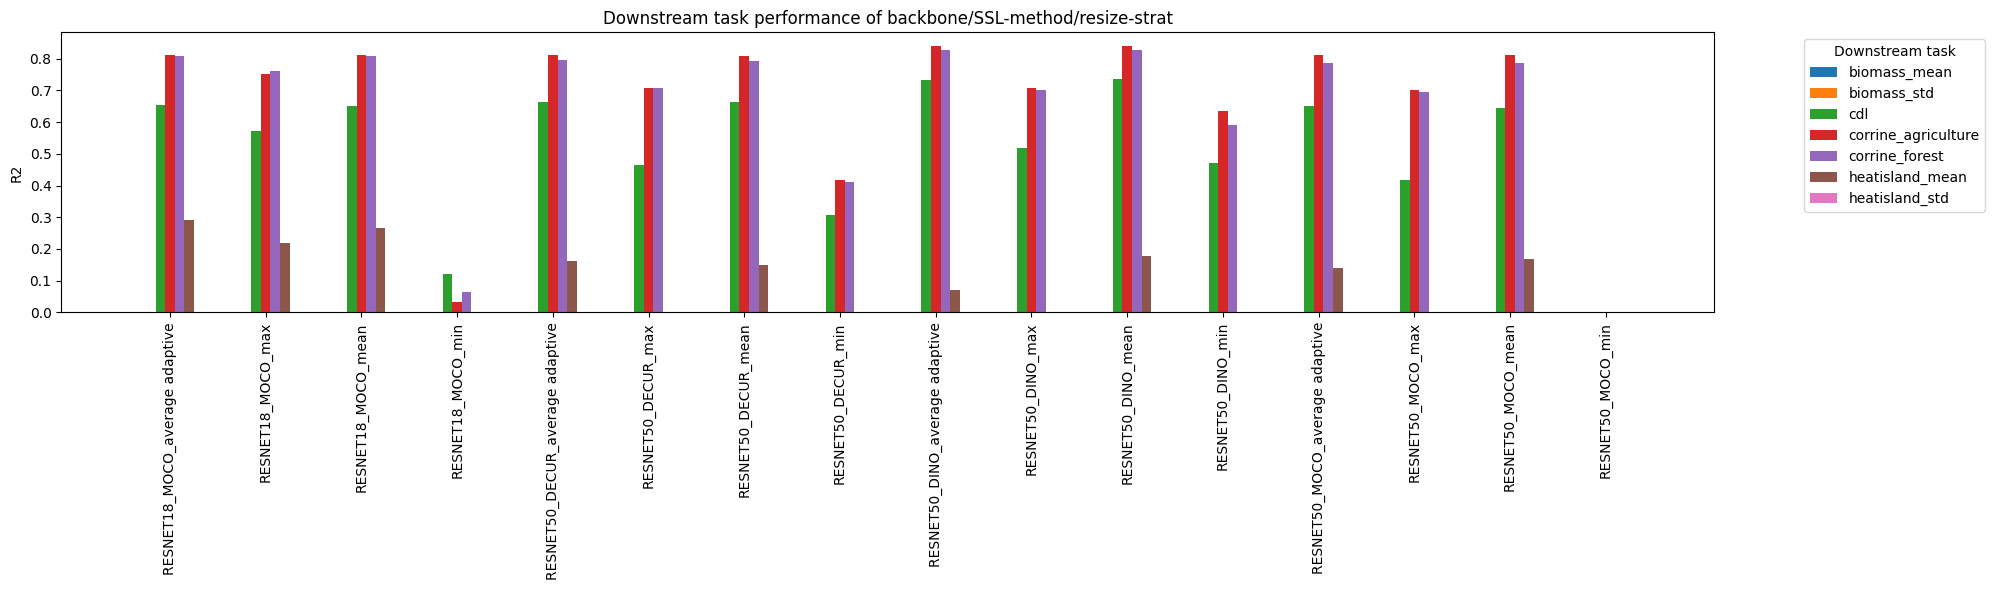

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Combine 'backbone' and 'method' into a single label
resnet_eval_df['model_label'] = resnet_eval_df['backbone'] + "_" + resnet_eval_df['method'] + "_" + resnet_eval_df['resize']

# Select numeric columns
numeric_cols = resnet_eval_df.select_dtypes(include='number').columns
x_labels = resnet_eval_df['model_label']
x = np.arange(len(x_labels))  # Positions on x-axis

bar_width = 0.1  # Width of each bar
n_metrics = len(numeric_cols)

plt.figure(figsize=(20, 6))

# Plot each metric as a group of bars
for i, col in enumerate(numeric_cols):
    offset = (i - n_metrics / 2) * bar_width + bar_width / 2
    plt.bar(x + offset, resnet_eval_df[col], width=bar_width, label=col)

plt.xticks(x, x_labels, rotation=90)
plt.ylabel("R2")
plt.title("Downstream task performance of backbone/SSL-method/resize-strat")
plt.legend(title="Downstream task", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## ViT intermediate layer

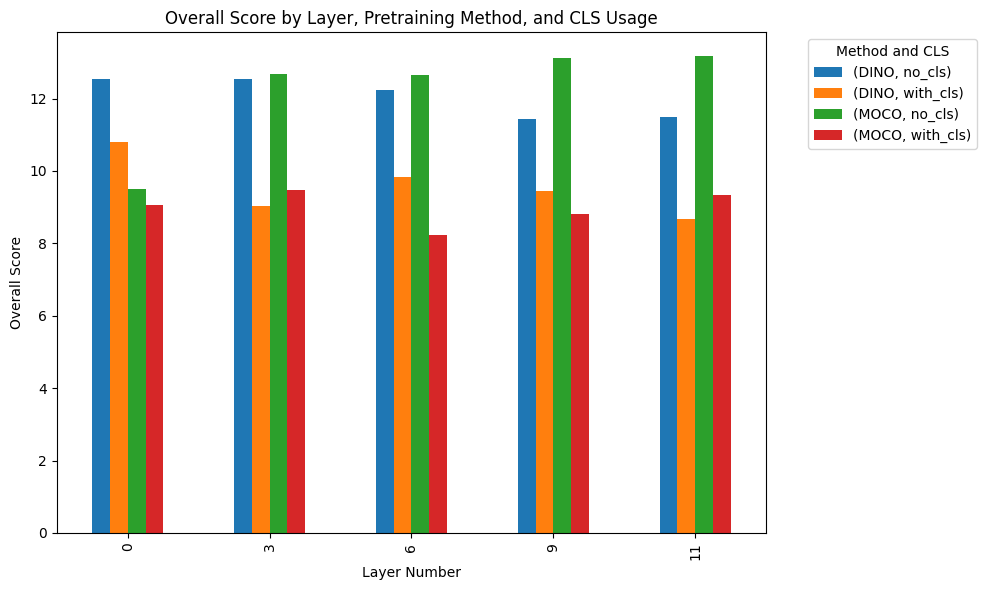

In [2]:
import glob
import json
import re
import pandas as pd
import matplotlib.pyplot as plt

# Load all JSON files
json_files = glob.glob('/Users/luisgilch/Desktop/analysis_intermediatelayers/*/results_summary.json')
records = []
for file in json_files:
    with open(file, 'r') as f:
        data = json.load(f)
    exp_name = data.get('experiment', '')
    
    # Parse experiment name: VIT16_{pretrain}_{...}
    parts = exp_name.split('_')
    pretrain = parts[1] if len(parts) > 1 else 'UNKNOWN'
    cls_flag = 'cls' in parts
    layer_match = re.search(r'layer(\d+)', exp_name)
    layer = int(layer_match.group(1)) if layer_match else None
    
    records.append({
        'layer': layer,
        'pretrain': pretrain,
        'cls': 'with_cls' if cls_flag else 'no_cls',
        'overall_score': data.get('overall_score', None)
    })

if not records:
    print("No JSON files loaded. Please check the path to your JSON result files.")
else:
    df = pd.DataFrame(records)
    pivot_df = df.pivot(index='layer', columns=['pretrain', 'cls'], values='overall_score').sort_index()
    fig, ax = plt.subplots(figsize=(10, 6))
    pivot_df.plot(kind='bar', ax=ax)
    ax.set_xlabel('Layer Number')
    ax.set_ylabel('Overall Score')
    ax.set_title('Overall Score by Layer, Pretraining Method, and CLS Usage')
    ax.legend(title='Method and CLS', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

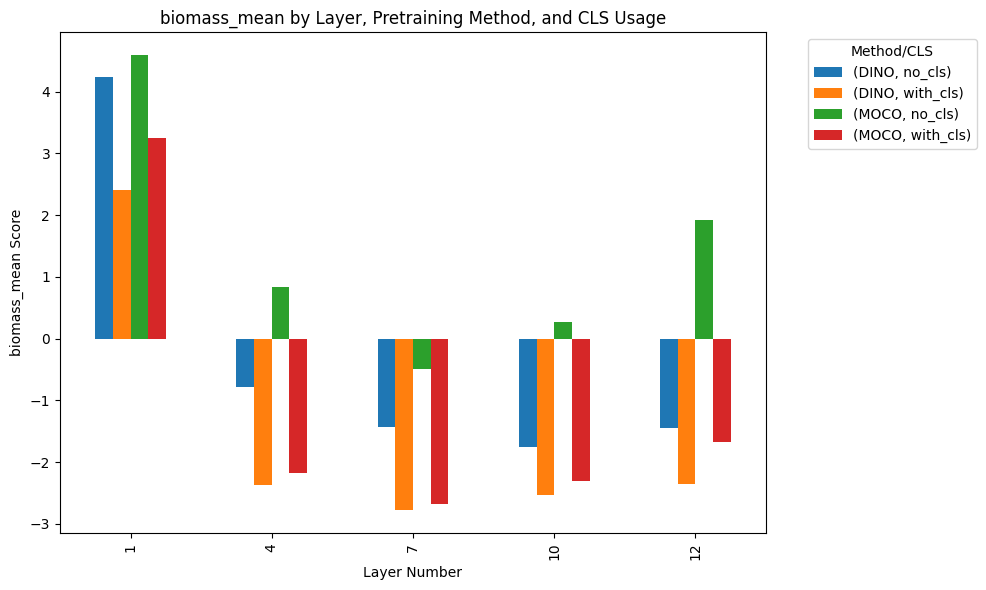

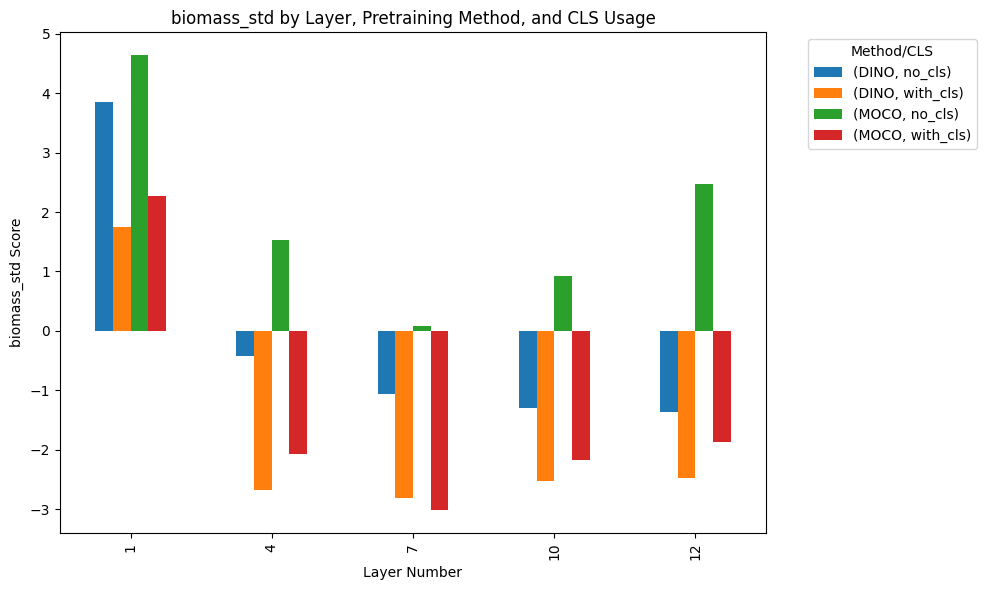

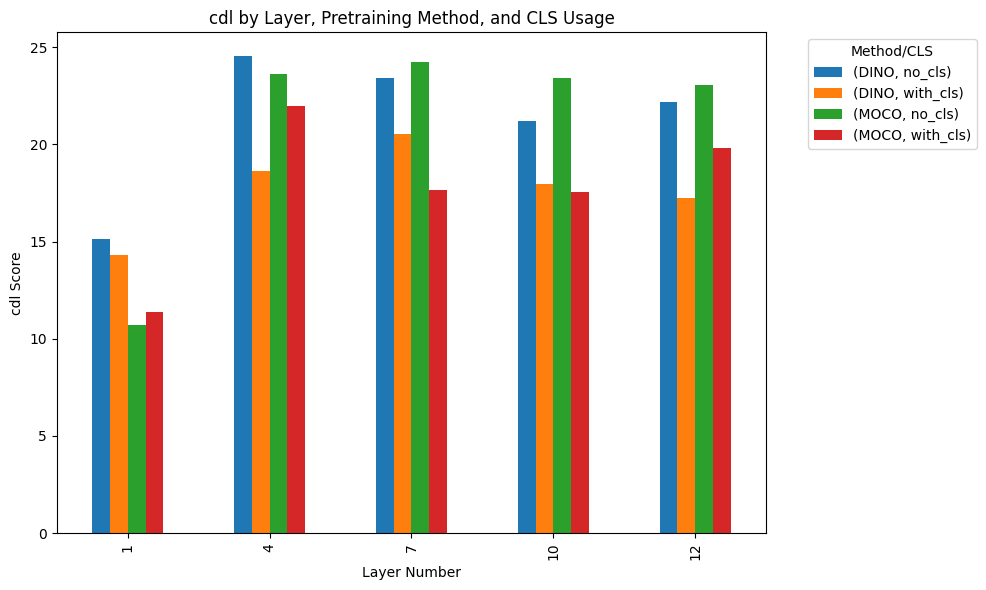

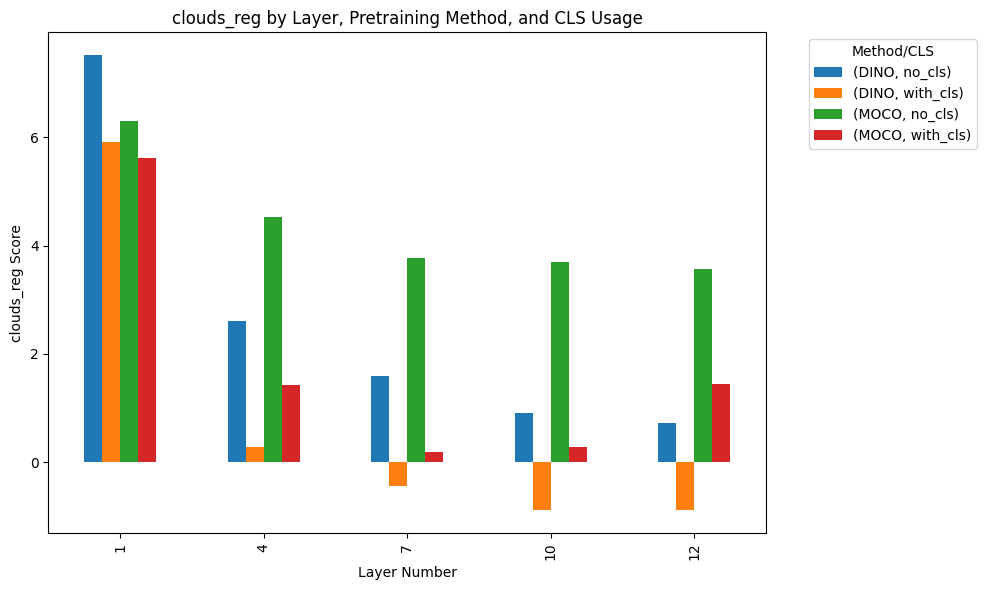

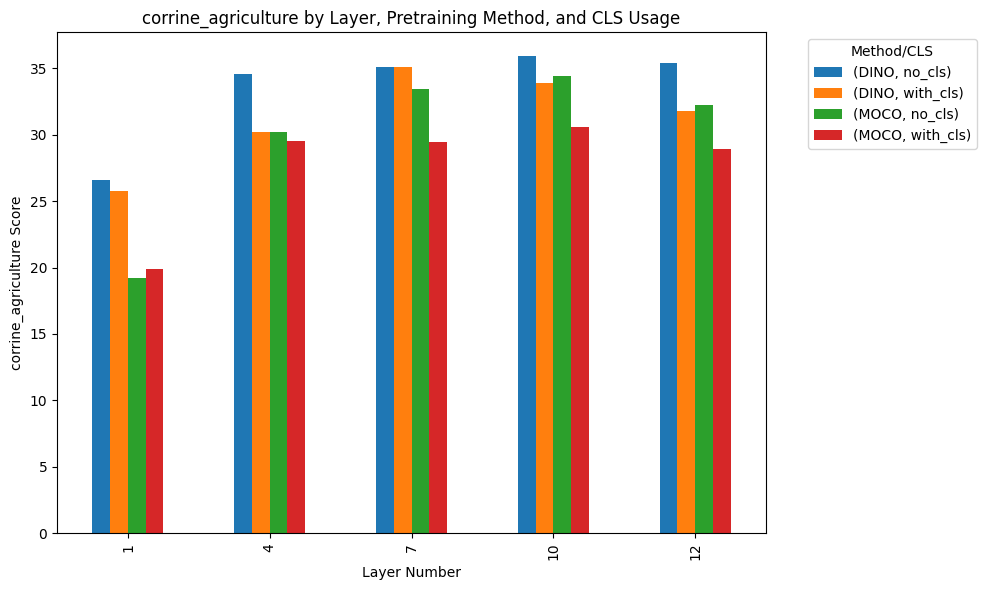

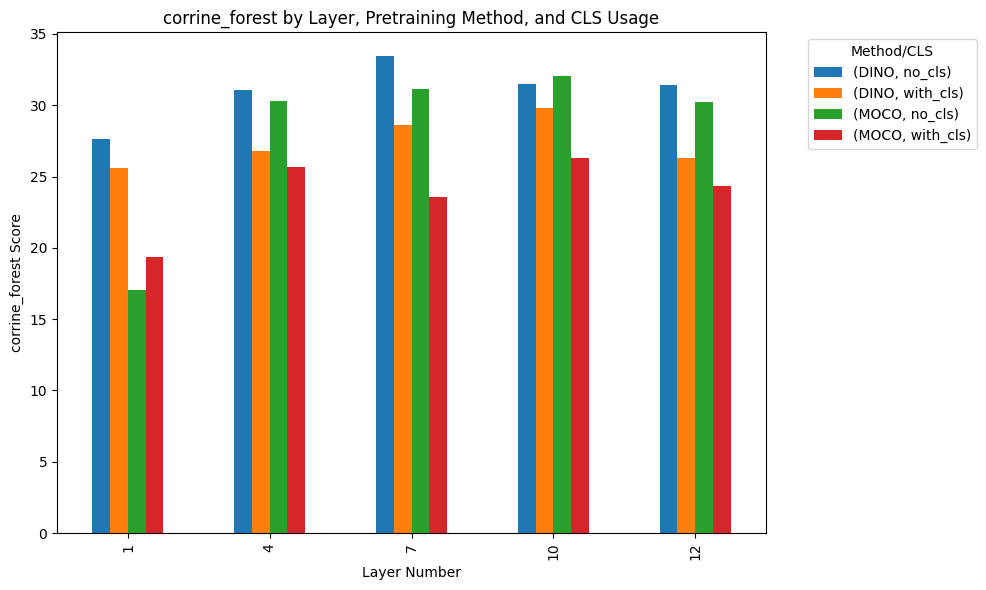

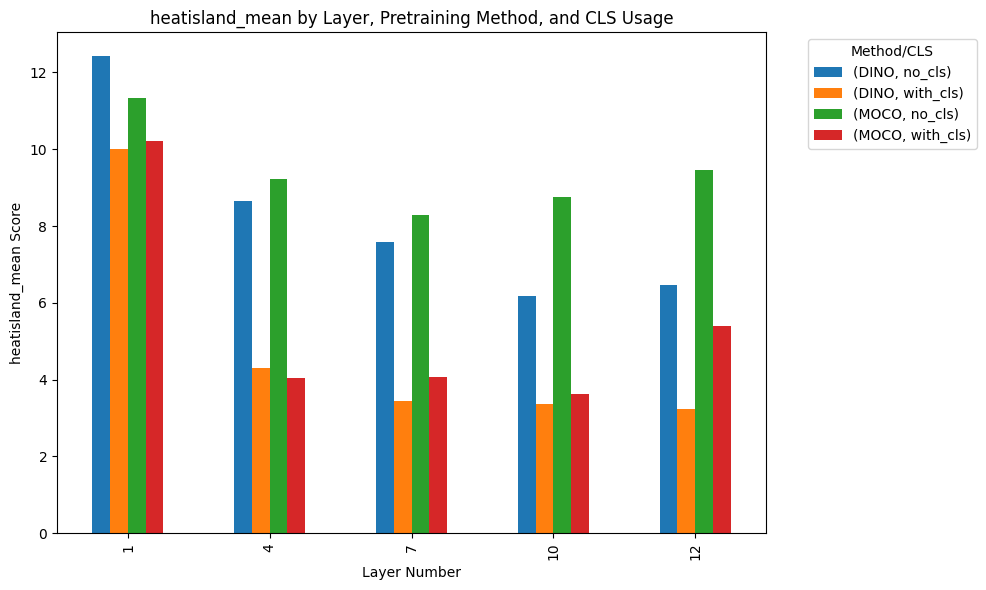

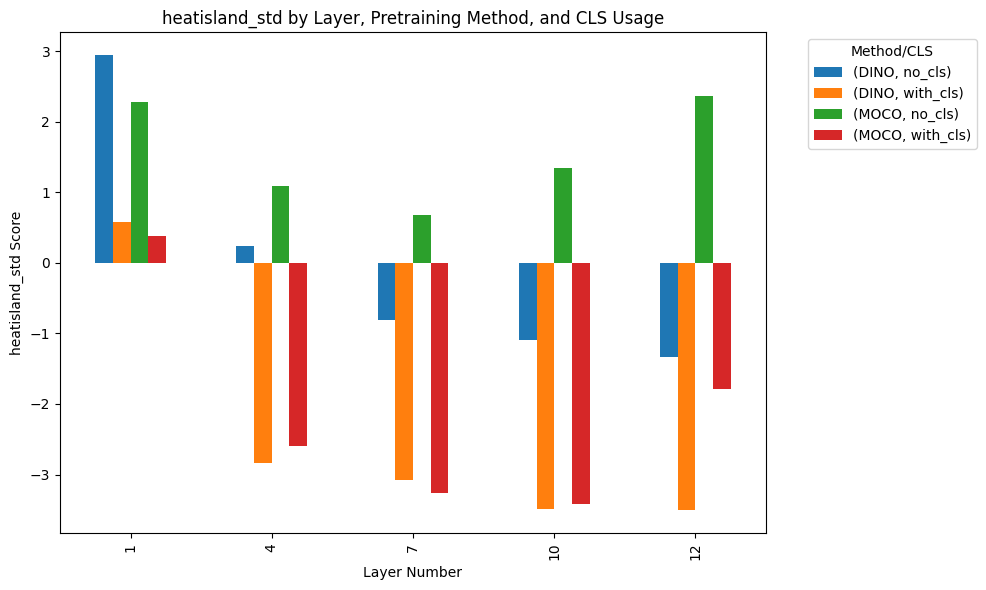

In [5]:
import glob
import json
import re
import pandas as pd
import matplotlib.pyplot as plt

# Adjust the base path as needed
json_files = glob.glob('/Users/luisgilch/Desktop/analysis_intermediatelayers/*/results_summary.json')

# Define the desired x-tick labels
xticks = [1, 4, 7, 10, 12]
xtick_labels = [str(x) for x in xticks]

records = []
for file in json_files:
    with open(file, 'r') as f:
        data = json.load(f)
    exp_name = data.get('experiment', '')
    parts = exp_name.split('_')
    pretrain = parts[1] if len(parts) > 1 else 'UNKNOWN'
    cls_flag = 'cls' in parts
    layer_match = re.search(r'layer(\d+)', exp_name)
    layer = int(layer_match.group(1)) if layer_match else None

    # Flatten each task result into separate records
    task_results = data.get('task_results', {})
    for task, score in task_results.items():
        records.append({
            'layer': layer,
            'pretrain': pretrain,
            'cls': 'with_cls' if cls_flag else 'no_cls',
            'task': task,
            'score': score
        })

if not records:
    print("No task records found. Check your path and JSON structure.")
else:
    df = pd.DataFrame(records)
    tasks = sorted(df['task'].unique())
    
    # Create one plot per downstream task
    for task in tasks:
        task_df = df[df['task'] == task]
        pivot_df = task_df.pivot(index='layer', columns=['pretrain','cls'], values='score').sort_index()
        
        fig, ax = plt.subplots(figsize=(10, 6))
        pivot_df.plot(kind='bar', ax=ax)
        ax.set_xlabel('Layer Number')
        ax.set_ylabel(f'{task} Score')
        ax.set_title(f'{task} by Layer, Pretraining Method, and CLS Usage')
        ax.set_xticklabels(xtick_labels)
        ax.legend(title='Method/CLS', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

## Plotting R2 over noise (Q_score)

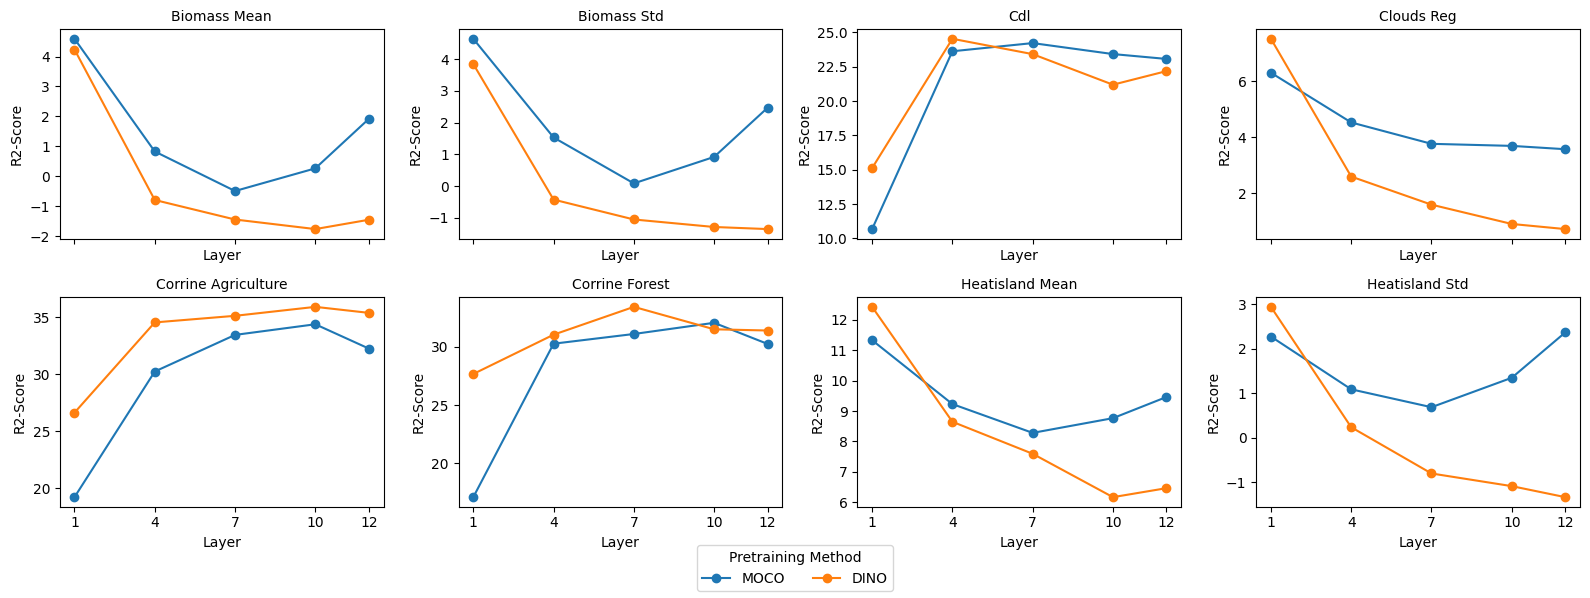

In [1]:
import glob, json, re, math
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load & flatten your JSON summaries
json_files = glob.glob('/Users/luisgilch/Desktop/analysis_intermediatelayers/*/results_summary.json')
records = []
for fn in json_files:
    d = json.load(open(fn))
    exp = d['experiment']
    parts = exp.split('_')
    pre = parts[1]              # MOCO or DINO
    has_cls = 'cls' in parts
    layer = int(re.search(r'layer(\d+)', exp).group(1)) + 1

    for task, score in d['task_results'].items():
        records.append({
            'layer': layer,
            'pretrain': pre,
            'cls': 'with_cls' if has_cls else 'no_cls',
            'task': task,
            'score': score
        })

df = pd.DataFrame(records)

# 2) Filter out CLS-runs (since your paragraph focuses on patch-level only)
df = df[df.cls == 'no_cls']

# 3) Figure layout: 2 rows × 4 columns
tasks = sorted(df.task.unique())
n_cols = 4
n_rows = math.ceil(len(tasks)/n_cols)
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(4*n_cols, 3*n_rows),
                         sharey=False, sharex=True)

# 4) Plot each task
xticks = [1,4,7,10,12]
for ax, task in zip(axes.flatten(), tasks):
    sub = df[df.task == task]
    for pre in ['MOCO','DINO']:
        seg = sub[sub.pretrain == pre].sort_values('layer')
        ax.plot(seg.layer, seg.score, marker='o', label=pre)
    ax.set_title(task.replace('_',' ').title(), fontsize=10)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.set_xlabel('Layer')
    ax.set_ylabel('R2-Score')

# 5) Hide any leftover axes
for ax in axes.flatten()[len(tasks):]:
    ax.axis('off')

# 6) One legend at bottom
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
           title='Pretraining Method',
           loc='lower center', ncol=2)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


In [11]:
#df.to_csv("vit16_results_layer.csv", index=False)

## Plotting R2 Score

   layer       pretrain     cls             task     score
0      1  DINO ViT (FM)  no_cls              cdl  0.572989
1      1  DINO ViT (FM)  no_cls   corrine_forest  0.720978
2      1  DINO ViT (FM)  no_cls     biomass_mean  0.306830
3      1  DINO ViT (FM)  no_cls      biomass_std  0.231443
4      1  DINO ViT (FM)  no_cls  heatisland_mean  0.542775


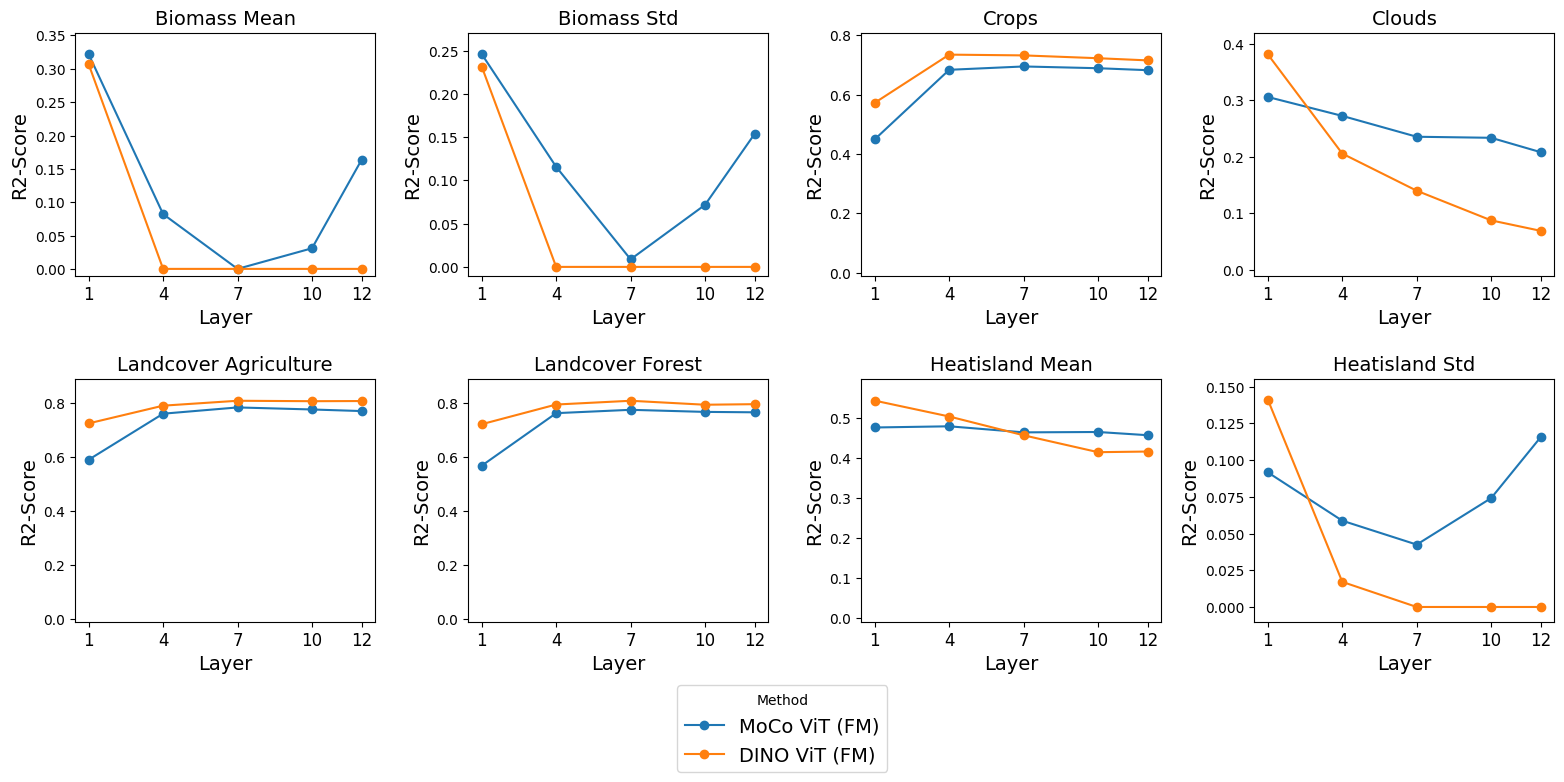

In [93]:
import glob, json, re, os, math
import pandas as pd
import matplotlib.pyplot as plt

# Define task list
tasks = [
    "biomass_mean",
    "biomass_std",
    "cdl",
    "clouds_reg",
    "corrine_agriculture",
    "corrine_forest",
    "heatisland_mean",
    "heatisland_std"
]

# Glob all *_result.json files recursively
json_files = glob.glob('/Users/luisgilch/Desktop/analysis_intermediatelayers/**/*_result.json', recursive=True)

records = []

for file_path in json_files:
    filename = os.path.basename(file_path)
    task_match = re.match(r'([a-z_]+)_result\.json', filename)
    if not task_match:
        continue

    task = task_match.group(1)
    if task not in tasks:
        continue  # skip unknown tasks

    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
            score = data.get('mean_score', None)
    except Exception as e:
        print(f"Failed to load {file_path}: {e}")
        continue

    # Go up two levels: task folder -> experiment folder
    experiment_dir = os.path.dirname(os.path.dirname(file_path))
    exp_name = os.path.basename(experiment_dir)
    parts = exp_name.split('_')

    pretrain = parts[1] if len(parts) > 1 else 'UNKNOWN'
    has_cls = 'cls' in parts
    layer_match = re.search(r'layer(\d+)', exp_name)
    layer = int(layer_match.group(1)) + 1 if layer_match else None

    if score is not None and layer is not None:
        #print(f"Adding: layer={layer}, pretrain={pretrain}, cls={'with_cls' if has_cls else 'no_cls'}, task={task}, score={score}")
        records.append({
            'layer': layer,
            'pretrain': pretrain,
            'cls': 'with_cls' if has_cls else 'no_cls',
            'task': task,
            'score': score
        })

# Convert to DataFrame
df = pd.DataFrame(records)
df.loc[df["score"] < 0, "score"] = 0
df.loc[df["pretrain"] == "DINO", "pretrain"] = "DINO ViT (FM)"
df.loc[df["pretrain"] == "MOCO", "pretrain"] = "MoCo ViT (FM)"

# OPTIONAL: print to confirm structure
print(df.head())

# Filter to no_cls
df = df[df.cls == 'no_cls']

# Plot
task_title_map = {
    "biomass_mean": "Biomass Mean",
    "biomass_std": "Biomass Std",
    "cdl": "Crops",
    "clouds_reg": "Clouds",
    "corrine_agriculture": "Landcover Agriculture",
    "corrine_forest": "Landcover Forest",
    "heatisland_mean": "Heatisland Mean",
    "heatisland_std": "Heatisland Std"
}

tasks = sorted(df.task.unique())
n_cols = 4
n_rows = math.ceil(len(tasks)/n_cols)
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(4*n_cols, 4*n_rows),
                         sharey=False, sharex=False)

xticks = [1, 4, 7, 10, 12]
color_map = {'MoCo ViT (FM)': 'tab:lightskyblue', 'DINO ViT (FM)': 'tab:blue'}
for ax, task in zip(axes.flatten(), tasks):
    sub = df[df.task == task]
    max_score = sub['score'].max()
    padded_ylim = max_score * 1.1  # Add 5% padding
    for pre in ['MoCo ViT (FM)', 'DINO ViT (FM)']:
        color=color_map[pre]
        seg = sub[sub.pretrain == pre].sort_values('layer')
        ax.plot(seg.layer, seg.score, marker='o', label=pre)
    title = task_title_map.get(task, task.replace('_', ' ').title())
    ax.set_title(title, fontsize=14)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize=12)
    ax.set_xlabel('Layer', fontsize=14)
    ax.set_ylabel('R2-Score', fontsize=14)
    ax.set_ylim(-0.01, padded_ylim)

# Hide extra axes
for ax in axes.flatten()[len(tasks):]:
    ax.axis('off')

# Add legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels,
           title='Method',
           loc='lower center',
           ncol=1,
           fontsize=14)

plt.tight_layout(rect=[0, 0.10, 1, 1], pad=2.0)
plt.show()

fig.savefig('vit16_intermediate_R2.svg', format='svg', dpi=1200)

In [ ]:
import os

base_dir = '/Users/luisgilch/Desktop/analysis_intermediatelayers'

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('_result.json'):
            print(os.path.join(root, file))


In [15]:
with open('/Users/luisgilch/Desktop/analysis_intermediatelayers/VIT16_MOCO_mean_pooling_layer11_cls_embeddings_20250512_122528/cdl/cdl_result.json') as f:
    data = json.load(f)
    print(data)

{'q_stat': 19.80768618487798, 'mean_score': 0.6080009508132934, 'std_dev': 0.04139040624315494}
